### Project

In [ ]:
from keras import layers
from keras import models

from keras import optimizers

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import CSVLogger
from keras.applications import VGG16

import os

import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def save_model(model, model_name):
    model.save(home_dir + 'models/' + model_name + '.h5')
    
def load_model(model_name):
    return models.load_model(home_dir + 'models/' + model_name + '.h5')

def load_history(model_name):
    return pd.read_csv(home_dir + 'logs/'+ model_name +'.log', sep=',', engine='python')
  
def display_loss_acc_curve(history):
    
    acc = history['acc']
    val_acc = history['val_acc']
    epochs = range(1, len(acc) + 1)

    loss = history['loss']
    val_loss = history['val_loss']
    
    fig, ax = plt.subplots(1,2, figsize=(18,6))
    ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'orange', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    #fig, ax = plt.subplots(figsize=(8,5))
    ax[1].plot(epochs, loss, 'bo', label='Training loss')
    ax[1].plot(epochs, val_loss, 'orange', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('loss')
    ax[1].legend()


    plt.show()

In [ ]:
### Paths
home_dir = '/content/gdrive/My Drive/image_project/'
train_dir = os.path.join(home_dir, 'train')
validation_dir = os.path.join(home_dir, 'validation')

### Image preprocessing

In [0]:
# Disply some examples

In [0]:
young_train_dir = os.path.join(train_dir, 'young')
fnames_young = [os.path.join(young_train_dir, fname) for fname in os.listdir(young_train_dir)]


In [0]:
img_size = (128,128,3)
batch_size = 32

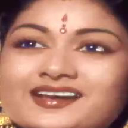

In [11]:
image.load_img(fnames_young[10], target_size=img_size)

In [0]:
middle_train_dir = os.path.join(train_dir, 'middle')
fnames_middle = [os.path.join(middle_train_dir, fname) for fname in os.listdir(middle_train_dir)]

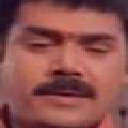

In [42]:
image.load_img(fnames_middle[16], target_size=img_size)

In [0]:
old_train_dir = os.path.join(train_dir, 'old')
fnames_old = [os.path.join(old_train_dir, fname) for fname in os.listdir(old_train_dir)]

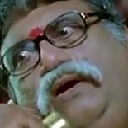

In [18]:
image.load_img(fnames_old[32], target_size=img_size)

In [0]:
train_datagen = ImageDataGenerator(rescale=1./255) #Rescales all images by 1/255
validation_datagen = ImageDataGenerator(rescale=1./255)


In [20]:
train_generator = train_datagen.flow_from_directory(
                    train_dir, # Target directory
                    target_size=img_size[:2], # Resize all images to 128x128 
                    batch_size=batch_size,
                    color_mode='rgb', 
                    class_mode='categorical')

Found 4800 images belonging to 3 classes.


In [21]:
validation_generator = validation_datagen.flow_from_directory(
                    validation_dir, # Target directory
                    target_size=img_size[:2], # Resize all images to 128x128 
                    batch_size=batch_size,
                    color_mode='rgb',
                    class_mode='categorical')

Found 2396 images belonging to 3 classes.


#### Printing random picture to check generator.

data batch shape: (32, 128, 128, 3)
labels batch shape: (32, 3)
Label:  [1. 0. 0.]


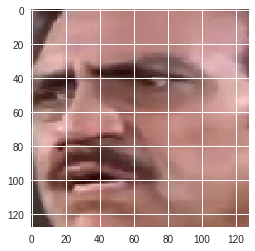

In [22]:
for data_batch, labels_batch in train_generator:
  
  plt.figure()
  imgplot = plt.imshow(image.array_to_img(data_batch[0]))
  
  print('data batch shape:', data_batch.shape)
  print('labels batch shape:', labels_batch.shape)
  print('Label: ', labels_batch[0])
  break
  plt.show()

### Model 1: Reference model

In [0]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=img_size) )
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])


model_name = 'model_baseline'

In [73]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 12, 12, 128)       147584    
__________

In [0]:
# Save history of training
csv_logger = CSVLogger(home_dir + 'logs/'+ model_name +'.log', separator=',', append=False)

In [0]:
#Fit model
history = model.fit_generator(
          train_generator,
          steps_per_epoch=150,
          epochs=30,
          validation_data=validation_generator,
          validation_steps=75,
          verbose = 1,
          callbacks=[csv_logger])

In [0]:
save_model(model, model_name)

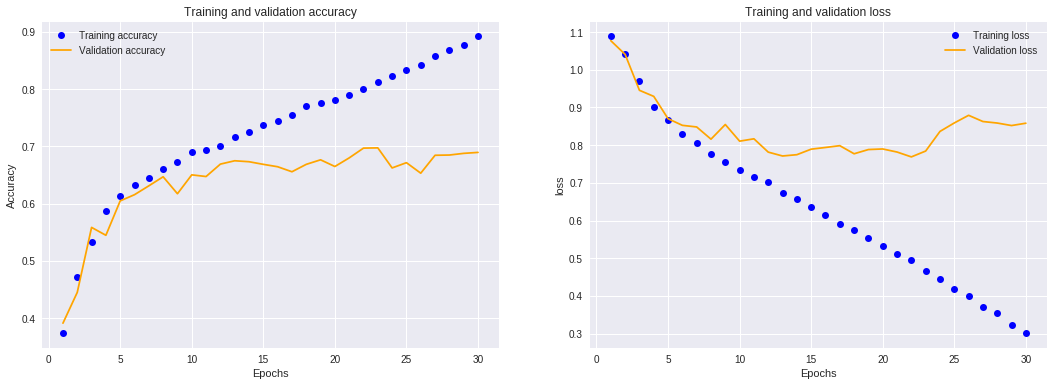

In [100]:
display_loss_acc_curve(history.history)

### Model 2: Implement some regularization techniques (Dropout + batchNormalization)

In [0]:
  model = models.Sequential()

  model.add( layers.Conv2D(32, (3,3), activation='relu', input_shape=img_size) )
  model.add(layers.BatchNormalization(axis=1))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.BatchNormalization(axis=1))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.BatchNormalization(axis=1))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.BatchNormalization(axis=1))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.BatchNormalization(axis=1))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dropout(0.3))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.BatchNormalization(axis=1))
  model.add(layers.Dropout(0.3))
  model.add(layers.Dense(3, activation='softmax'))
  
  model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])
  
  model_name = 'model_BN_dropout'

In [112]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_59 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_18 (Batc (None, 126, 126, 32)      504       
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_19 (Batc (None, 61, 61, 64)        244       
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 28, 28, 128)       73856     
__________

In [0]:
# Save history of training
csv_logger = CSVLogger(home_dir + 'logs/'+ model_name +'.log', separator=',', append=False)

In [0]:
history = model.fit_generator(
          train_generator,
          steps_per_epoch=150,
          epochs=30,
          validation_data=validation_generator,
          validation_steps=75,
          verbose = 0,
          callbacks=[csv_logger])

In [0]:
save_model(model, model_name)

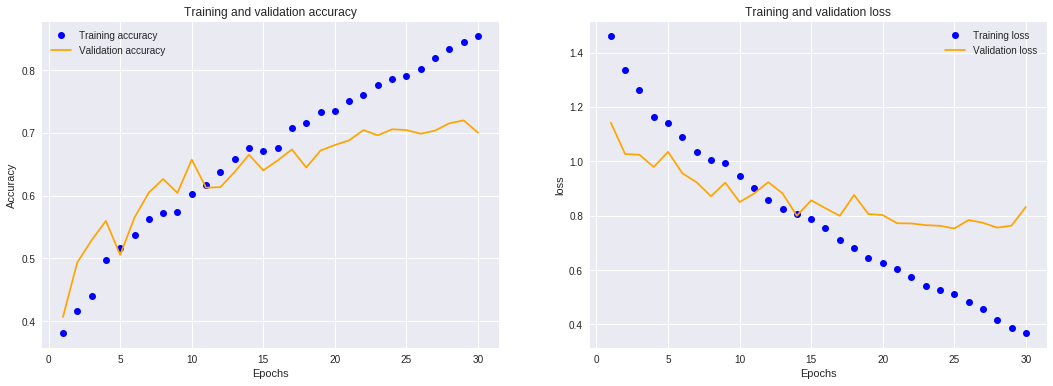

In [116]:
display_loss_acc_curve(history.history)

### Data augmentation

In [0]:
train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.1,
            fill_mode='nearest')


# Note that validation dataset shouldn't be augmented
validation_datagen = ImageDataGenerator(
            rescale=1./255)

In [0]:
# Displaying some randomly augmented training images

In [0]:
img = image.load_img(fnames_young[10], target_size=img_size)

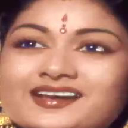

In [13]:
img

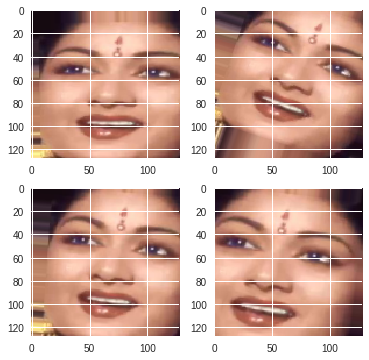

In [14]:
x = image.img_to_array(img) #Converts it to a Numpy array with shape (128, 128, 3)
x = x.reshape((1,) + x.shape) #Reshapes it to (1, 128, 128, 3)

# Generates batches of randomly transformed images. Loops indefinitely, so you need to break the loop at some point!
i = 0
imgs = []
for batch in train_datagen.flow(x, batch_size=1):
  imgs.append(image.array_to_img(batch[0])) 
  i += 1
  if i % 4 == 0:
    break

fig=plt.figure(figsize=(6, 6))

for i, img in enumerate(imgs):
    fig.add_subplot(2, 2, i+1)
    plt.imshow(img)
    
plt.show()

**Note:** By data augmentation we can’t produce new information, we only remix existing information

### Model 3: Training the convnet using data-augmentation generators

In [19]:
train_generator = train_datagen.flow_from_directory(
                    train_dir, # Target directory
                    target_size=img_size[:2], # Resize all images to 128x128 
                    batch_size=batch_size,
                    color_mode='rgb', 
                    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
                    validation_dir, # Target directory
                    target_size=img_size[:2], # Resize all images to 128x128 
                    batch_size=batch_size,
                    color_mode='rgb',
                    class_mode='categorical')

Found 4800 images belonging to 3 classes.
Found 2396 images belonging to 3 classes.


In [0]:
  model = models.Sequential()

  model.add( layers.Conv2D(32, (3,3), activation='relu', input_shape=img_size) )
  #model.add(layers.BatchNormalization(axis=1))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  #model.add(layers.BatchNormalization(axis=1))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  #model.add(layers.BatchNormalization(axis=1))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  #model.add(layers.BatchNormalization(axis=1))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  #model.add(layers.BatchNormalization(axis=1))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dropout(0.3))
  model.add(layers.Dense(3, activation='softmax'))
  
  model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])
  
  model_name = 'model_data_augm3'

In [0]:
# Save history of training
csv_logger = CSVLogger(home_dir + 'logs/'+ model_name +'.log', separator=',', append=False)

In [20]:
150*32

4800

In [21]:
history = model.fit_generator(
          train_generator,
          steps_per_epoch=150,
          epochs=50,
          validation_data=validation_generator,
          validation_steps=75,
          callbacks=[csv_logger])

Epoch 1/50
150/150 [==============================] - 2829s 19s/step - loss: 1.0947 - acc: 0.3613 - val_loss: 1.0874 - val_acc: 0.3427
Epoch 2/50
150/150 [==============================] - 39s 261ms/step - loss: 1.0663 - acc: 0.4329 - val_loss: 1.0340 - val_acc: 0.4695
Epoch 3/50
150/150 [==============================] - 39s 259ms/step - loss: 1.0133 - acc: 0.4952 - val_loss: 0.9928 - val_acc: 0.5259
Epoch 4/50
150/150 [==============================] - 39s 257ms/step - loss: 0.9651 - acc: 0.5306 - val_loss: 0.9396 - val_acc: 0.5772
Epoch 5/50
150/150 [==============================] - 38s 253ms/step - loss: 0.9355 - acc: 0.5548 - val_loss: 0.9211 - val_acc: 0.5768
Epoch 6/50
150/150 [==============================] - 38s 252ms/step - loss: 0.9188 - acc: 0.5727 - val_loss: 0.8835 - val_acc: 0.6131
Epoch 7/50
150/150 [==============================] - 39s 260ms/step - loss: 0.8938 - acc: 0.5908 - val_loss: 0.8831 - val_acc: 0.6127
Epoch 8/50
150/150 [==============================] - 3

In [0]:
save_model(model, model_name)

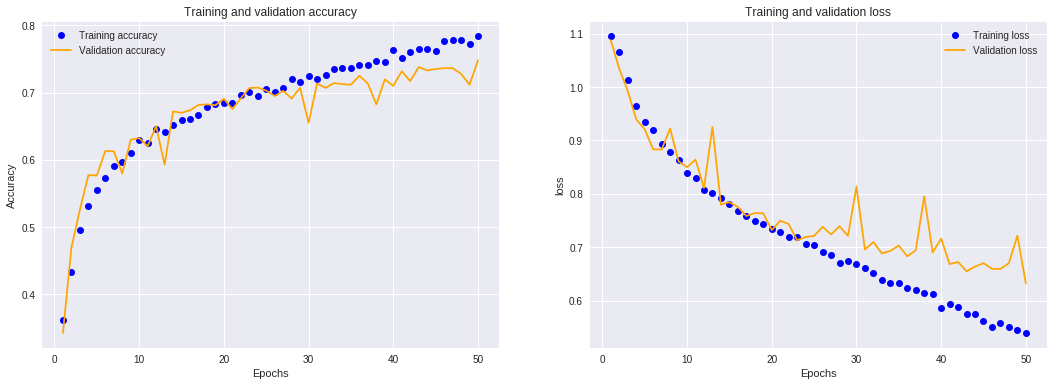

In [23]:
display_loss_acc_curve(history.history)

### Using a pretrained convnet
Instantiating the VGG16 convolutional base

In [0]:
conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=img_size)

In [25]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

####  Two approaches to use pretrained convNet:
Running the convolutional base over your dataset, recording its output to a Numpy array on disk, and then using this data as input to a standalone, densely connected classifier.

Extending the model you have (conv_base) by adding Dense layers on top, and running the whole thing end to end on the input data.

**Approach 1:** extracting features using the pretrained convolutional base

In [0]:
datagen = ImageDataGenerator(rescale=1./255)

In [0]:
def extract_features(directory, sample_count):
  
    features = np.zeros(shape=(sample_count, 4,4, 512))
    labels = np.zeros(shape=(sample_count, 3))
  
  
    generator = datagen.flow_from_directory(
                      directory,
                      target_size=img_size[:2],
                      batch_size=batch_size,
                      class_mode='categorical')
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i+1)*batch_size] = features_batch
        labels[i * batch_size: (i+1)*batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
              break
      
    return features, labels  

In [0]:
generate_features = True

In [52]:
#Train features

if generate_features:

      train_features, train_labels = extract_features(train_dir, 4800)

  #Save extracted features from VGG16:
      with open(home_dir + 'models/vgg16/train_features.pickle', 'wb') as f:
          pickle.dump([train_features, train_labels]  ,f)

              f.close()

Found 4800 images belonging to 3 classes.


In [53]:
#Validation features

if generate_features:

      validation_features, validation_labels = extract_features(validation_dir, 2396)

  #Save extracted features from VGG16:
    with open(home_dir + 'models/vgg16/validation_features.pickle', 'wb') as f:
        pickle.dump([validation_features, validation_labels]  ,f)

          f.close()

Found 2396 images belonging to 3 classes.


In [0]:
#Load features from hard disc:

with open(home_dir + 'models/vgg16/train_features.pickle', 'rb') as f:
    load_train = pickle.load(f)
    f.close()

train_features, train_labels = load_train


with open(home_dir + 'models/vgg16/validation_features.pickle', 'rb') as f:
    load_validation = pickle.load(f)
    f.close()

validation_features, validation_labels = load_validation

Extracted features shape:

In [54]:
for item in [train_features.shape, train_labels.shape, validation_features.shape, validation_labels.shape]:
    print(item)

(4800, 4, 4, 512)
(4800, 3)
(2396, 4, 4, 512)
(2396, 3)


Extracted features need to be flatten, to feed a densely connected classifier

In [0]:
tr_feat_shape = train_features.shape
vd_feat_shape = validation_features.shape

In [0]:
train_features = np.reshape(train_features, (tr_feat_shape[0], tr_feat_shape[1]*tr_feat_shape[2]*tr_feat_shape[3]))
validation_features = np.reshape(validation_features, (vd_feat_shape[0], vd_feat_shape[1]*vd_feat_shape[2]*vd_feat_shape[3]))

Build and train fully connected NN classifier

In [0]:
def build_fc_nn():
  
    model = models.Sequential()
    
    model.add(layers.Dense(512, activation='relu', input_dim=(tr_feat_shape[1]*tr_feat_shape[2]*tr_feat_shape[3])))
    model.add(layers.Dense(3, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])
  
    return model  

In [0]:
model = build_fc_nn()

In [0]:
# Save history of training
csv_logger = CSVLogger(home_dir + 'logs/model_conv_base_01.log', separator=',', append=False)

In [0]:
history = model.fit(train_features, train_labels,
                   epochs=100,
                   batch_size=batch_size,
                   validation_data=(validation_features, validation_labels),
                   callbacks=[csv_logger])

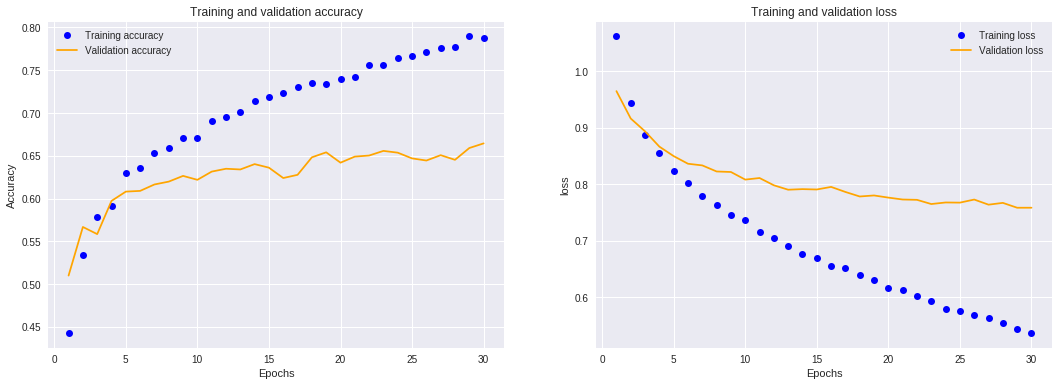

In [62]:
display_loss_acc_curve(history.history)

**Approach 2:** Adding a densely connected classifier on top of the convolutional base and run the whole net end to end.

This approach is much slower and more computational expensive, but allow to use data augmentation.

In [ ]:
conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=img_size)

In [ ]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

In [ ]:
model_name = 'model_vgg16_frozen'

In [ ]:
conv_base.trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-5), metrics=['acc'])

In [ ]:
model.summary()

In [ ]:
# Save history of training
csv_logger = CSVLogger(home_dir + 'logs/'+ model_name +'.log', separator=',', append=False)

In [ ]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=150,
        epochs=50,
        callbacks=[csv_logger],
        validation_data=validation_generator,
        validation_steps=75      
)

In [ ]:
save_model(model, model_name)

In [ ]:
display_loss_acc_curve(history)

#### VGG16 with all weights trainable

In [10]:
conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=img_size)

58892288/58889256 [==============================] - 3s 0us/step


In [0]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

In [0]:
 model_name = 'model_vgg16_trainable'

In [0]:
conv_base.trainable = True

In [0]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-5), metrics=['acc'])

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                4128      
__________

In [0]:
# Save history of training
csv_logger = CSVLogger(home_dir + 'logs/'+ model_name +'.log', separator=',', append=False)

In [0]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=150,
        epochs=50,
        callbacks=[csv_logger],
        validation_data=validation_generator,
        validation_steps=75      
)

Epoch 1/50
149/150 [============================>.] - ETA: 13s - loss: 1.0494 - acc: 0.4480

In [3]:
save_model(model, model_name)